# Tutorial for Saving and Loading in Lompe
Lompe relies on xarray datasets to produce easy to use collections of data that can include the standard lompe output or even the parameters required to save the model object.

In this tutorial we will replicate lompe model created in a demo script

### Necessary Imports

In [15]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta
from lompe.utils.conductance import hardy_EUV
import apexpy
import lompe

### Grid setup

In [2]:
# set up grid
position = (-90, 65) # lon, lat
orientation = (-1, 2) # east, north
L, W, Lres, Wres = 4200e3, 7000e3, 100.e3, 100.e3 # dimensions and resolution of grid
grid = lompe.cs.CSgrid(lompe.cs.CSprojection(position, orientation), L, W, Lres, Wres, R = 6481.2e3)

### Data setup

In [3]:
conductance_functions = True

event = '2012-04-05'
apex = apexpy.Apex(int(event[0:4]), refh = 110)

supermagfn = './sample_dataset/20120405_supermag.h5'
superdarnfn = './sample_dataset/20120405_superdarn_grdmap.h5'
iridiumfn = './sample_dataset/20120405_iridium.h5'
# load ampere, supermag, and superdarn data from 2012-05-05
ampere    = pd.read_hdf(iridiumfn)
supermag  = pd.read_hdf(supermagfn)
superdarn = pd.read_hdf(superdarnfn)
# these files contain entire day. Function to select from a smaller time interval is needed:
def prepare_data(t0, t1):
    """ get data from correct time period """
    # prepare ampere
    amp = ampere[(ampere.time >= t0) & (ampere.time <= t1)]
    B = np.vstack((amp.B_e.values, amp.B_n.values, amp.B_r.values))
    coords = np.vstack((amp.lon.values, amp.lat.values, amp.r.values))
    amp_data = lompe.Data(B * 1e-9, coords, datatype = 'space_mag_fac', scale = 200e-9)

    # prepare supermag
    sm = supermag[t0:t1]
    B = np.vstack((sm.Be.values, sm.Bn.values, sm.Bu.values))
    coords = np.vstack((sm.lon.values, sm.lat.values))
    sm_data = lompe.Data(B * 1e-9, coords, datatype = 'ground_mag', scale = 100e-9)

    # prepare superdarn
    sd = superdarn.loc[(superdarn.index >= t0) & (superdarn.index <= t1)]
    vlos = sd['vlos'].values
    coords = np.vstack((sd['glon'].values, sd['glat'].values))
    los  = np.vstack((sd['le'].values, sd['ln'].values))
    sd_data = lompe.Data(vlos, coordinates = coords, LOS = los, datatype = 'convection', scale = 500)
    
    return amp_data, sm_data, sd_data

### Create model

In [4]:

# times during entire day
times = pd.date_range('2012-04-05 00:00', '2012-04-05 23:59', freq = '3Min')[:10]
DT = timedelta(seconds = 2 * 60) # will select data from +- DT


Kp = 4 # for Hardy conductance model
SH = lambda lon = grid.lon, lat = grid.lat: hardy_EUV(lon, lat, 5, times[0], 'hall'    )
SP = lambda lon = grid.lon, lat = grid.lat: hardy_EUV(lon, lat, 5, times[0], 'pedersen')
model = lompe.Emodel(grid, Hall_Pedersen_conductance = (SH, SP))

### Saving a single time step
Now I will show you how to save a single time step of the model and the model output

First we need to run the inversion for this time step

In [5]:
t= times[0]
SH = lambda lon = grid.lon, lat = grid.lat: hardy_EUV(lon, lat, 5, t, 'hall'    )
SP = lambda lon = grid.lon, lat = grid.lat: hardy_EUV(lon, lat, 5, t, 'pedersen')
    
model.clear_model(Hall_Pedersen_conductance = (SH, SP)) # reset

amp_data, sm_data, sd_data = prepare_data(t - DT, t + DT)

model.add_data(amp_data, sm_data, sd_data)

gtg, ltl = model.run_inversion(l1 = 2, l2 = 0)

In [6]:
ds= model.save(time=t, parameters_to_save='all')

saving................. : ['model', 'data_locations', 'efield', 'convection', 'ground_mag', 'electric_current', 'space_mag_fac', 'space_mag_full', 'fac', 'hall', 'pedersen', 'secs_current']


Setting parameters_to_save to 'all we save all the required parameters for recreating the model object, all outputs from lompe and all locations of the data used for the inversion

In [7]:
ds

<xarray.Dataset>
Dimensions:                        (time: 1, eta: 54, xi: 38)
Coordinates:
  * xi                             (xi) float64 -0.2875 -0.2721 ... 0.2833
  * eta                            (eta) float64 -0.4119 -0.3965 ... 0.4058
    lon                            (xi, eta) float64 -42.85 -44.19 ... -145.0
    lat                            (xi, eta) float64 50.88 51.03 ... 56.95 56.1
  * time                           (time) datetime64[ns] 2012-04-05
Data variables: (12/24)
    convection_E                   (time, eta, xi) float64 -273.7 ... -51.17
    convection_N                   (time, eta, xi) float64 -110.0 ... 37.38
    efield_E                       (time, eta, xi) float64 -0.005931 ... 0.00198
    efield_N                       (time, eta, xi) float64 0.01462 ... 0.002801
    electric_current_E             (time, eta, xi) float64 -0.001554 ... 0.04368
    electric_current_N             (time, eta, xi) float64 0.004167 ... 0.004224
    ...                             ...
    space_mag_full_N               (time, eta, xi) float64 1.255e-08 ... 1.43...
    space_mag_full_U               (time, eta, xi) float64 1.872e-09 ... -1.7...
    model_vector                   (time, eta, xi) float64 -469.4 ... -5.186
    convection_input_locations     (time) |S3584 b'\x00\x00\x00\xc0\x9d\xf6U\...
    ground_mag_input_locations     (time) |S3648 b'\xdf\x15\xc1\xff\xd6\xdbj@...
    space_mag_fac_input_locations  (time) |S880 b"\x1fV\xe12\xad\xa1j@\xdd\xf...
Attributes:
    Data_locs:    True
    Epoch:        2015.0
    Dipole:       False
    grid_info_E:  {'projection': {'position': [-90, 65], 'orientation': [-0.4...
    grid_info_J:  {'projection': {'position': [-90, 65], 'orientation': [-0.4...

In [8]:
ds= model.save(time=t, parameters_to_save='all model')
ds

saving................. : ['model', 'data_locations']


<xarray.Dataset>
Dimensions:                        (time: 1, eta: 54, xi: 38)
Coordinates:
  * xi                             (xi) float64 -0.2875 -0.2721 ... 0.2833
  * eta                            (eta) float64 -0.4119 -0.3965 ... 0.4058
    lon                            (xi, eta) float64 -42.85 -44.19 ... -145.0
    lat                            (xi, eta) float64 50.88 51.03 ... 56.95 56.1
  * time                           (time) datetime64[ns] 2012-04-05
Data variables:
    hall                           (time, eta, xi) float64 0.006137 ... 9.79
    pedersen                       (time, eta, xi) float64 0.008782 ... 8.425
    model_vector                   (time, eta, xi) float64 -469.4 ... -5.186
    convection_input_locations     (time) |S3584 b'\x00\x00\x00\xc0\x9d\xf6U\...
    ground_mag_input_locations     (time) |S3648 b'\xdf\x15\xc1\xff\xd6\xdbj@...
    space_mag_fac_input_locations  (time) |S880 b"\x1fV\xe12\xad\xa1j@\xdd\xf...
Attributes:
    Data_locs:    True
    Epoch:        2015.0
    Dipole:       False
    grid_info_E:  {'projection': {'position': [-90, 65], 'orientation': [-0.4...
    grid_info_J:  {'projection': {'position': [-90, 65], 'orientation': [-0.4...

Using 'all model' the locations of data input and all parameters needed to recreate the model object will be in the dataset.

There are a wide range of strings that can be used or lists of strings, read the docstring to know what to set the parameters_to_save argument as.

### Load grid

the output of model save will always include the information needed to recreate the cubedsphere grid used in lompe model even if the parameters_to_save is empty.

The load_grid function will use the attributes of the dataset to reproduce the cubedsphere grids

In [9]:
grid_J, grid_E= lompe.model.model.load_grid(ds)
grid_J

53 x 37 cubed sphere grid
Centered at lon, lat = -90.0, 65.0
Orientation: -0.45 east, 0.89 north, 
Extent: ~31.6 x 45.6 degrees central angle

### Load model
Using the load_model function we can recreate the model object using the information in the dataset
If input data locations are stored then dummy data is created to allow the locations to be added to lompe output plots. The model must also be loaded using a time for cases where the dataset contains a time series

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana


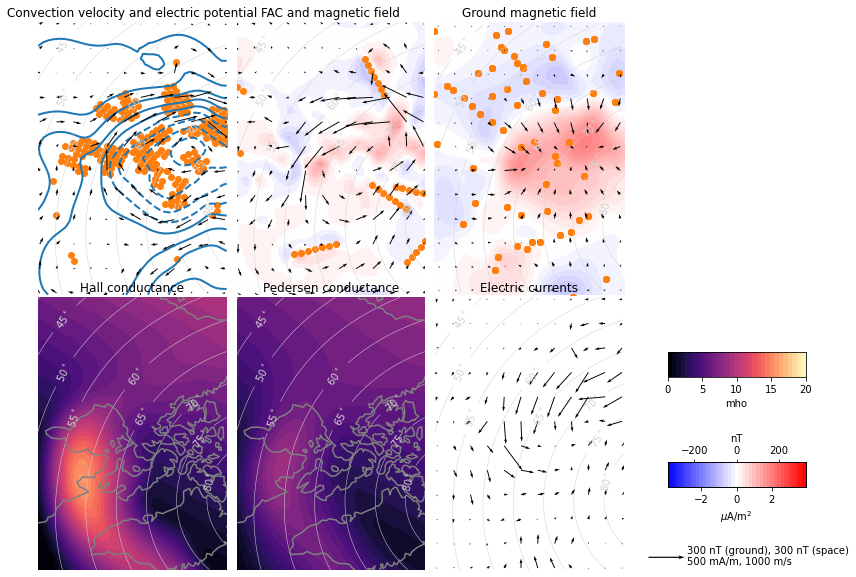

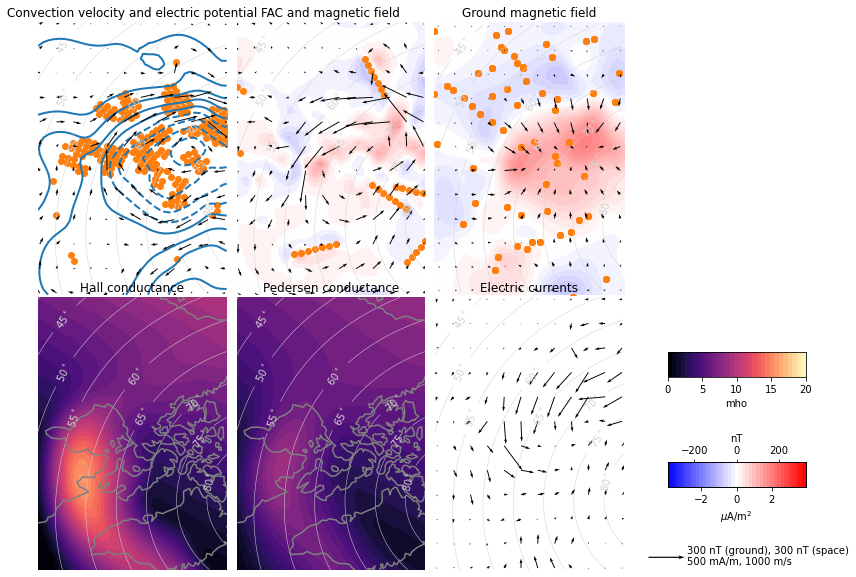

In [10]:
recreated_lompe= lompe.model.model.load_model(ds, time=t)
lompe.lompeplot(recreated_lompe, show_data_location=True)

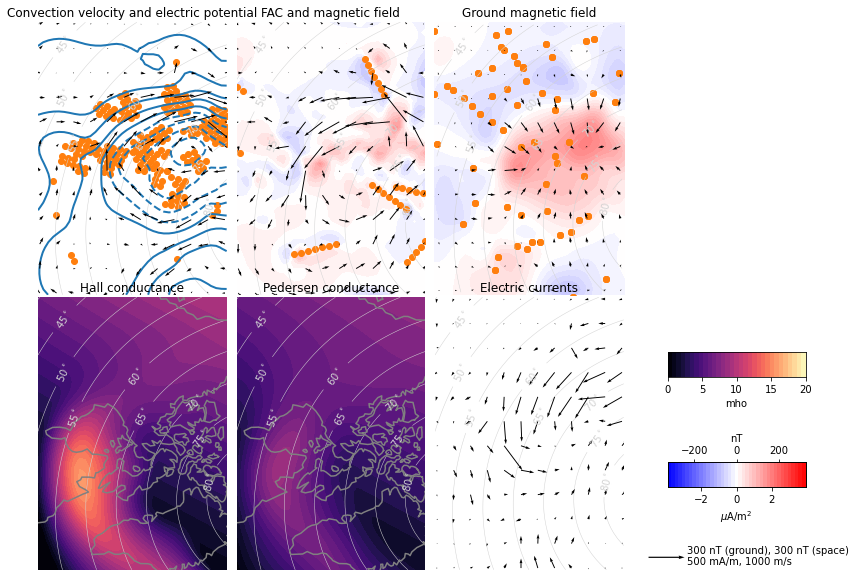

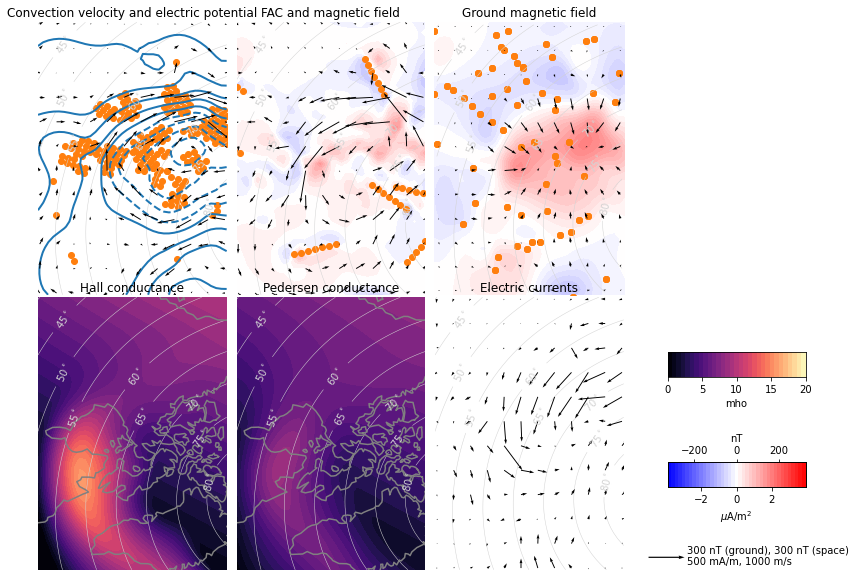

In [11]:
lompe.lompeplot(model, show_data_location=True)

If the required parameters are not included in the dataset then an error is raise

In [12]:
ds=model.save(parameters_to_save='all output')
recreated_model=lompe.model.model.load_model(ds, time=t)

saving................. : ['efield', 'convection', 'ground_mag', 'electric_current', 'space_mag_fac', 'space_mag_full', 'fac', 'hall', 'pedersen', 'secs_current']


ArgumentError: data set does not include: model_vector they are required to recreate the model object please include these parameters when using the save function

### Working with a time series
It is recommended to store each dataset from each time step in a list to joined afterwards

In [13]:
data_sets=[]
# loop through times
for t in times[1:]:
    print(t)
    
    SH = lambda lon = grid.lon, lat = grid.lat: hardy_EUV(lon, lat, 5, t, 'hall'    )
    SP = lambda lon = grid.lon, lat = grid.lat: hardy_EUV(lon, lat, 5, t, 'pedersen')

    model.clear_model(Hall_Pedersen_conductance = (SH, SP)) # reset
    
    amp_data, sm_data, sd_data = prepare_data(t - DT, t + DT)
    
    model.add_data(amp_data, sm_data, sd_data)

    gtg, ltl = model.run_inversion(l1 = 2, l2 = 0)
    
    data_sets.append(model.save(time=t, suppress_print=True))

2012-04-05 00:03:00
2012-04-05 00:06:00
2012-04-05 00:09:00
2012-04-05 00:12:00
2012-04-05 00:15:00
2012-04-05 00:18:00
2012-04-05 00:21:00
2012-04-05 00:24:00
2012-04-05 00:27:00


The datasets can then be combined using xarray concat and using the time dimension

In [16]:
ds= xr.concat(data_sets, dim='time')
ds

<xarray.Dataset>
Dimensions:                        (time: 9, eta: 54, xi: 38)
Coordinates:
  * xi                             (xi) float64 -0.2875 -0.2721 ... 0.2833
  * eta                            (eta) float64 -0.4119 -0.3965 ... 0.4058
    lon                            (xi, eta) float64 -42.85 -44.19 ... -145.0
    lat                            (xi, eta) float64 50.88 51.03 ... 56.95 56.1
  * time                           (time) datetime64[ns] 2012-04-05T00:03:00 ...
Data variables: (12/24)
    convection_E                   (time, eta, xi) float64 -204.3 ... -113.9
    convection_N                   (time, eta, xi) float64 -50.94 ... 67.96
    efield_E                       (time, eta, xi) float64 -0.002826 ... 0.00...
    efield_N                       (time, eta, xi) float64 0.01092 ... 0.00635
    electric_current_E             (time, eta, xi) float64 -0.0008678 ... 0.0...
    electric_current_N             (time, eta, xi) float64 0.00366 ... 0.0173
    ...                             ...
    space_mag_full_N               (time, eta, xi) float64 -3.357e-09 ... -2....
    space_mag_full_U               (time, eta, xi) float64 -1.92e-09 ... 3.26...
    model_vector                   (time, eta, xi) float64 -439.8 ... -549.4
    convection_input_locations     (time) |S15968 b'\x00\x00\x00\xc0\x9d\xf6U...
    ground_mag_input_locations     (time) |S6080 b'\xdf\x15\xc1\xff\xd6\x7fp@...
    space_mag_fac_input_locations  (time) |S1616 b'3\xads\x07\xc4+k@\x83J\xa7...
Attributes:
    Data_locs:    True
    Epoch:        2015.0
    Dipole:       False
    grid_info_E:  {'projection': {'position': [-90, 65], 'orientation': [-0.4...
    grid_info_J:  {'projection': {'position': [-90, 65], 'orientation': [-0.4...

Finally we can select the model we want to load from the file by specifying the time

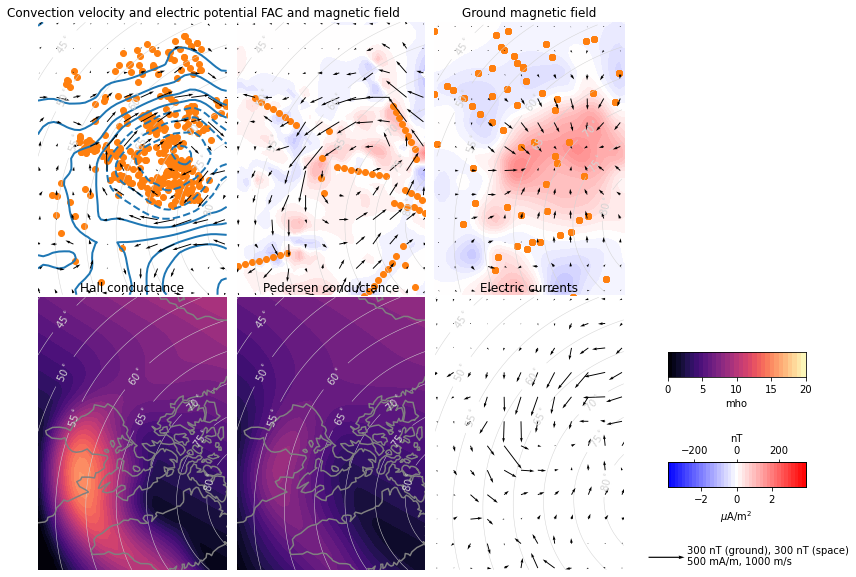

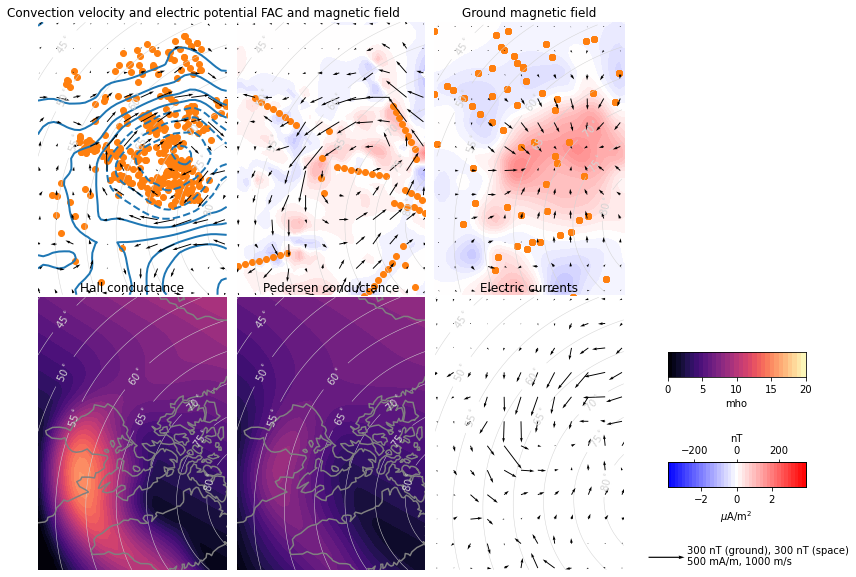

In [19]:
recreated_model=lompe.model.model.load_model(ds, time=times[1])
lompe.lompeplot(recreated_model, show_data_location=True)